In [1]:
from typing import List

import numpy as np
from genobs.experiment_parameters import *
from genobs.Rubidium87_operators import *
from genobs.visualizations import *
from qutip import *
from copy import copy
from lmfit.model import Model

In [2]:
def hamil(
    mw_det,
    b_longitudinal=0.1,
    bvector=[0, 0, 0],
    laser_intens=OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL / 500,
):
    ham_laser_atom = H_atom_field_D1(-1, E_0_plus(laser_intens)).full()
    ham_laser_atom[:3, :] = 0  # F=1 -> F' neglected
    ham_laser_atom[:, :3] = 0
    hb_ac = H_B("D1", bx=bvector[0], by=bvector[1], bz=bvector[2])
    hb_ac = hb_ac.full()
    for k in range(16):
        hb_ac[k, k] = 0.0  # rotating...
    hb_ac[8:, 8:] = 0.0
    h0 = H_atom(0, "D1") + H_B("D1", bz=b_longitudinal)
    # h0 = h0.full()
    h0 = np.diag(h0.diag())
    ham_tot = Qobj(h0) + Qobj(hb_ac) + Qobj(ham_laser_atom)
    temp = ham_tot.full()
    laser_freq = temp[9, 9] - temp[5, 5]
    for k in range(8, 16):
        temp[k, k] -= laser_freq
    diff_f2_f1 = temp[5, 5] - temp[1, 1]
    for k in range(3):
        temp[k, k] += diff_f2_f1  # rotating frame mw: level of F=1 shifted to F=2
    for k in range(3):
        temp[k, k] += mw_det
    for i in range(15):  # RWA rf freqs
        temp[i, i + 1] = 0.0
        temp[i + 1, i] = 0.0
    return Qobj(temp)


def P_wire(b_mw, distance=0.03):
    from scipy import constants

    return (b_mw * 1e-4 / constants.mu_0 * distance * 2 * pi) ** 2 * 50


In [3]:
decays = (
    natural_decay_ops_D1()
    + quenching_ops("D1")
    + wall_coll("D1", gamma=2e3)
    + dephasing_excited_states("D1", gamma=1.6e8)
    # + dephasing_ground_states_D1()
)


def sim(bvector):

    laser_intens = 0.01 * 10  # W/m²
    b_longitudinal = 0.1  # G
    ham_mw_off = hamil(
        0, b_longitudinal=b_longitudinal, laser_intens=laser_intens, bvector=[0, 0, 0]
    )
    laser_ss = steadystate(ham_mw_off, c_op_list=decays)
    plot_bar_excited_pop_D1(laser_ss)
    plot_bar_ground_pop(laser_ss)
    mw_detuning = ham_mw_off[3, 3] - ham_mw_off[0, 0]  # MW sigma minus
    h = hamil(mw_detuning, b_longitudinal, laser_intens=laser_intens, bvector=bvector)

    # mw_ss = steadystate(h, c_op_list=decays)
    # plot_bar_excited_pop_D1(mw_ss-laser_ss)
    # plot_bar_ground_pop(mw_ss-laser_ss)

    time_evo_options = Options(nsteps=2**8 * 1000)
    res = mesolve(
        h,
        rho0=laser_ss,
        tlist=np.linspace(0, 1e-3, 5000),
        c_ops=decays,
        options=time_evo_options,
        progress_bar=True,
    )
    return res


def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
    # C = 1 - A - steady                                   # we set  f(t=0) = 1
    # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
    return (
        steady
        + A * np.exp(-gamma1 * t)
        + B * np.sin(rabi * t) * np.exp(-gamma2 * t)
        + C * np.cos(rabi * t) * np.exp(-gamma2 * t)
    )


mod = Model(rabi_osci_fctn, independent_vars=["t"])
pars = mod.make_params()
# try:
#     pars = copy(resfit.params)
# except NameError:
pars["gamma1"].set(value=5e3)  # , min=1e3, max=99e3)
pars["gamma2"].set(value=5e3)  # , min=1.000e3, max=66e3)
pars["rabi"].set(value=22e3, min=1e3, max=177e3)
# pars["A"].set(min=0, max=0.6, value=0.05)
# pars["B"].set(min=0, max=0.6, value=0.01)
# pars["C"].set(min=0, max=0.6, value=0.01)
pars["A"].set(value=0.05e-5)
pars["B"].set(value=0.1e-5)
pars["C"].set(value=0.1e-5)


def fit_rabi(sim_result):
    # plt.plot(res.times, exc_states)#/exc_states[0])

    exc_states = [sum(state.diag()[8:]) for state in sim_result.states]
    g = np.abs(exc_states)

    # plt.plot(g)

    # f2_states = np.array([sum(state.diag()[3:8]) for state in res.states])
    # # plt.plot(res.times, f2_states)#/f2_states[0])

    y = g
    t = sim_result.times

    pars["steady"].set(value=y[-1])  # , min=0.8, max=0.999)

    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="differential_evolution",
    )
    return resfit

10.0%. Run time:  17.68s. Est. time left: 00:00:02:39
20.0%. Run time:  34.87s. Est. time left: 00:00:02:19
30.0%. Run time:  52.13s. Est. time left: 00:00:02:01
40.0%. Run time:  69.77s. Est. time left: 00:00:01:44
50.0%. Run time:  86.97s. Est. time left: 00:00:01:26
60.0%. Run time: 104.25s. Est. time left: 00:00:01:09
70.0%. Run time: 121.70s. Est. time left: 00:00:00:52
80.0%. Run time: 139.81s. Est. time left: 00:00:00:34
90.0%. Run time: 157.29s. Est. time left: 00:00:00:17
Total run time: 174.53s


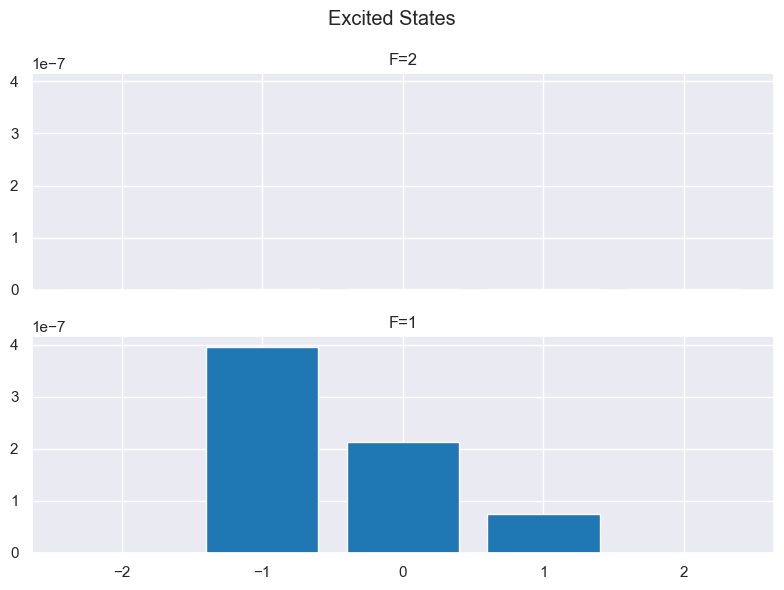

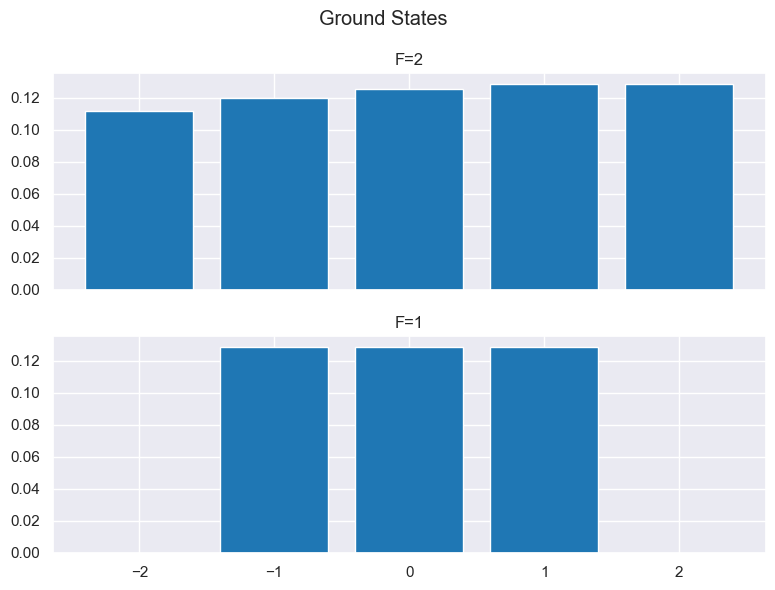

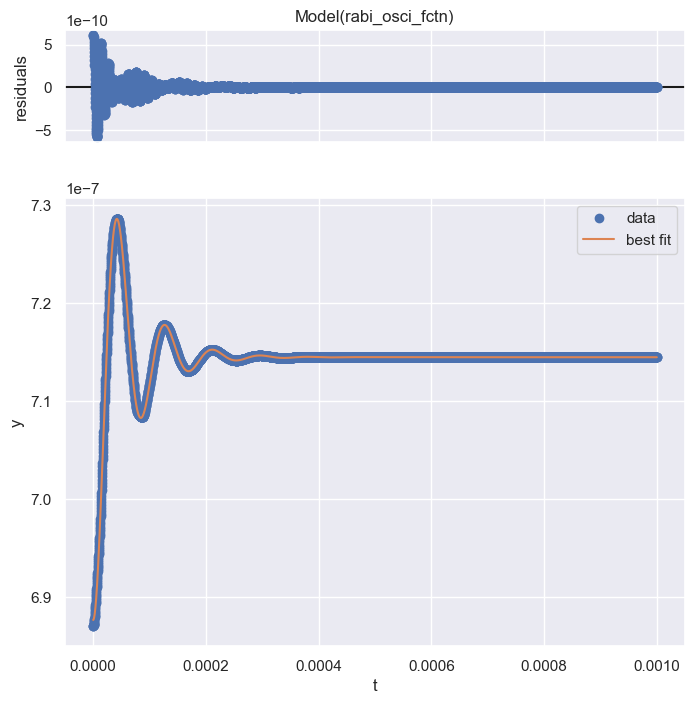

In [4]:
bx, by = Bxy_from_mw_rabi_sigma_plus_minus(80.871301e3, 67.557761e3)    # from experiment
bz = Bz_from_rabi_pi_clock(75e3)
s = sim((bx, by, bz))
f = fit_rabi(s)
f.plot()
f

In [5]:
1

1

In [6]:
def Bxy_from_mw_rabi_sigma_plus_minus(rabi_sigma_plus, rabi_sigma_minus):
    r"""
    MW Field Polarization
    Calculates Bx, By from Rabi frequencies at Mw sigma + and sigma - transitions:
    |1, 1 > with |2, 2 > and |1, -1 > with |2, -2 >
    """
    mu = 7628535.3802797925  #  = abs(H_B("D1", bx=1)[0, 3])
    return (
        (-rabi_sigma_plus + rabi_sigma_minus) / (2**1.5 * mu),
        -(rabi_sigma_plus + rabi_sigma_minus) / (2**1.5 * mu),
    )


In [7]:
from typing import List

import numpy as np
from genobs.experiment_parameters import *
from genobs.Rubidium87_operators import *
from genobs.visualizations import *
from qutip import *
from copy import copy
from lmfit.model import Model

In [8]:
def hamil(
    mw_det,
    b_longitudinal=0.1,
    bvector=[0, 0, 0],
    laser_intens=OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL / 500,
):
    ham_laser_atom = H_atom_field_D1(-1, E_0_plus(laser_intens)).full()
    ham_laser_atom[:3, :] = 0  # F=1 -> F' neglected
    ham_laser_atom[:, :3] = 0
    hb_ac = H_B("D1", bx=bvector[0], by=bvector[1], bz=bvector[2])
    hb_ac = hb_ac.full()
    for k in range(16):
        hb_ac[k, k] = 0.0  # rotating...
    hb_ac[8:, 8:] = 0.0
    h0 = H_atom(0, "D1") + H_B("D1", bz=b_longitudinal)
    # h0 = h0.full()
    h0 = np.diag(h0.diag())
    ham_tot = (
        Qobj(h0)
        + Qobj(hb_ac)
        + Qobj(ham_laser_atom)
    )
    temp = ham_tot.full()
    laser_freq = temp[9, 9] - temp[5, 5]
    for k in range(8, 16):
        temp[k, k] -= laser_freq
    diff_f2_f1 = temp[5, 5] - temp[1, 1]
    for k in range(3):
        temp[k, k] += diff_f2_f1  # rotating frame mw: level of F=1 shifted to F=2
    for k in range(3):
        temp[k, k] += mw_det
    for i in range(15):  # RWA rf freqs
        temp[i, i + 1] = 0.0
        temp[i + 1, i] = 0.0
    return Qobj(temp)


def P_wire(b_mw, distance=0.03):
    from scipy import constants

    return (b_mw * 1e-4 / constants.mu_0 * distance * 2 * pi) ** 2 * 50

In [9]:
sim_results = []
fit_results = []


decays = (
    natural_decay_ops_D1()
    + quenching_ops("D1")
    + wall_coll("D1", gamma=2e3)
    + dephasing_excited_states("D1", gamma=1.6e8)
    # + dephasing_ground_states_D1()
)


def sim(bvector):

    laser_intens = 0.01 * 10  # W/m²
    b_longitudinal = 0.1  # G
    ham_mw_off = hamil(
        0, b_longitudinal=b_longitudinal, laser_intens=laser_intens, bvector=[0, 0, 0]
    )
    laser_ss = steadystate(ham_mw_off, c_op_list=decays)
    plot_bar_excited_pop_D1(laser_ss)
    plot_bar_ground_pop(laser_ss)
    mw_detuning = ham_mw_off[3, 3] - ham_mw_off[0, 0]  # MW sigma minus
    h = hamil(mw_detuning, b_longitudinal, laser_intens=laser_intens, bvector=bvector)

    # mw_ss = steadystate(h, c_op_list=decays)
    # plot_bar_excited_pop_D1(mw_ss-laser_ss)
    # plot_bar_ground_pop(mw_ss-laser_ss)

    time_evo_options = Options(nsteps=2**8 * 1000)
    res = mesolve(
        h,
        rho0=laser_ss,
        tlist=np.linspace(0, 1e-3, 5000),
        c_ops=decays,
        options=time_evo_options,
        progress_bar=True,
    )
    return res


def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
    # C = 1 - A - steady                                   # we set  f(t=0) = 1
    # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
    return (
        steady
        + A * np.exp(-gamma1 * t)
        + B * np.sin(rabi * t) * np.exp(-gamma2 * t)
        + C * np.cos(rabi * t) * np.exp(-gamma2 * t)
    )


mod = Model(rabi_osci_fctn, independent_vars=["t"])
pars = mod.make_params()
# try:
#     pars = copy(resfit.params)
# except NameError:
pars["gamma1"].set(value=5e3)  # , min=1e3, max=99e3)
pars["gamma2"].set(value=5e3)  # , min=1.000e3, max=66e3)
pars["rabi"].set(value=22e3, min=1e3, max=177e3)
# pars["A"].set(min=0, max=0.6, value=0.05)
# pars["B"].set(min=0, max=0.6, value=0.01)
# pars["C"].set(min=0, max=0.6, value=0.01)
pars["A"].set(value=0.05e-5)
pars["B"].set(value=0.1e-5)
pars["C"].set(value=0.1e-5)


def fit_rabi(sim_result):
    # plt.plot(res.times, exc_states)#/exc_states[0])

    exc_states = [sum(state.diag()[8:]) for state in sim_result.states]
    g = np.abs(exc_states)

    # plt.plot(g)

    # f2_states = np.array([sum(state.diag()[3:8]) for state in res.states])
    # # plt.plot(res.times, f2_states)#/f2_states[0])

    y = g
    t = sim_result.times

    pars["steady"].set(value=y[-1])  # , min=0.8, max=0.999)

    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="differential_evolution",
    )
    return resfit

10.0%. Run time:  17.83s. Est. time left: 00:00:02:40
20.0%. Run time:  35.86s. Est. time left: 00:00:02:23
30.0%. Run time:  69.73s. Est. time left: 00:00:02:42
40.0%. Run time:  93.09s. Est. time left: 00:00:02:19
50.0%. Run time: 118.17s. Est. time left: 00:00:01:58
60.0%. Run time: 137.30s. Est. time left: 00:00:01:31
70.0%. Run time: 174.83s. Est. time left: 00:00:01:14
80.0%. Run time: 193.88s. Est. time left: 00:00:00:48
90.0%. Run time: 213.20s. Est. time left: 00:00:00:23
Total run time: 233.36s


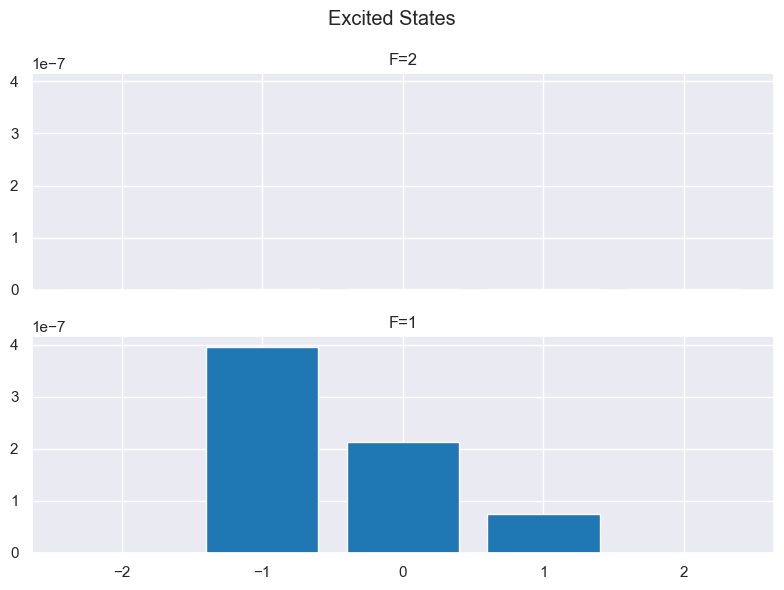

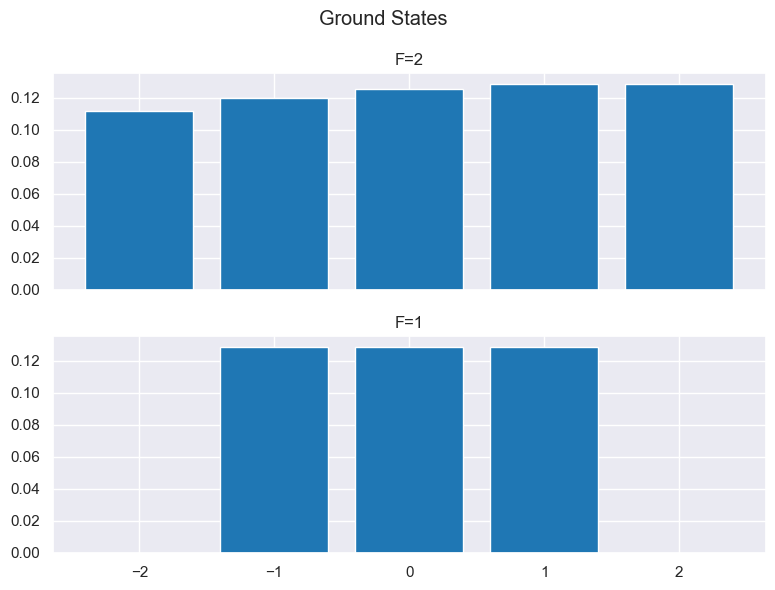

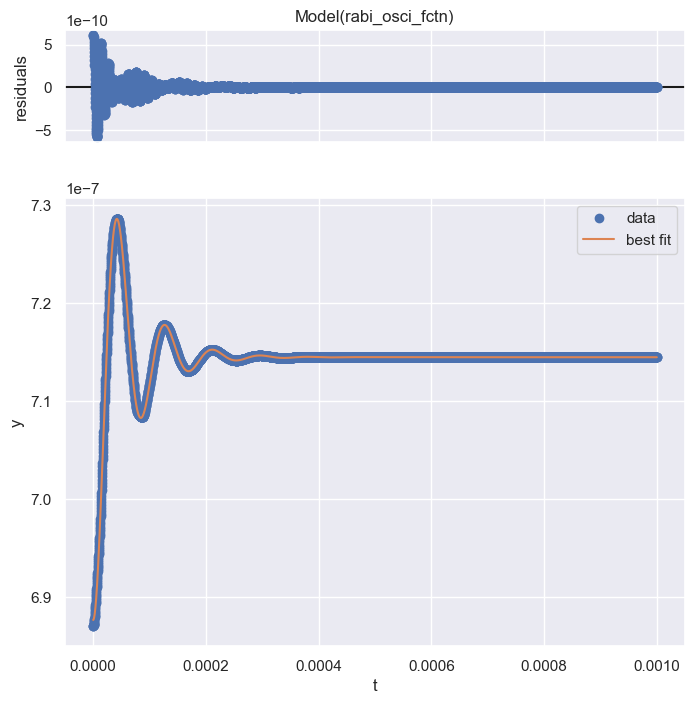

In [10]:
bx, by = Bxy_from_mw_rabi_sigma_plus_minus(80.871301e3, 67.557761e3)
bz = Bz_from_rabi_pi_clock(75e3)
s = sim((bx, by, bz))
f = fit_rabi(s)
f.plot()
f
# #%%

# for B in Bs:
#     sim_results.append(sim(B))
# for sim in sim_results:
#     fit_results.append(fit_rabi(sim))

# # %%
# for res in sim_results:
#     exc_states = np.array([sum(state.diag()[8:]) for state in res.states])
#     plt.plot(res.times, exc_states)
# # %%
# for res in fit_results:
#     res.plot()
# # %%
# from faraday import faraday_rot_angle

# angles = [faraday_rot_angle(st, -30e9) for st in sim_results[0].states]
# plt.plot(sim_results[0].times, angles)
# #%%
# y = angles
# t = sim_results[0].times
# pars["gamma1"].set(value=5e3)  # , min=1e3, max=99e3)
# pars["gamma2"].set(value=5e3)  # , min=1.000e3, max=66e3)
# pars["rabi"].set(value=22e3, min=0.1e3, max=177e3)
# # pars["A"].set(min=0, max=0.6, value=0.05)
# # pars["B"].set(min=0, max=0.6, value=0.01)
# # pars["C"].set(min=0, max=0.6, value=0.01)
# pars["A"].set(value=0.05e-1)
# pars["B"].set(value=0.1e-1)
# pars["C"].set(value=0.1e-1)
# pars["steady"].set(value=y[-1])  # , min=0.8, max=0.999)

# resfitfarad = mod.fit(
#     data=y,
#     t=t,
#     params=pars,
#     # method="differential_evolution",
# )
# resfitfarad.plot()
# resfitfarad
# # %%

In [11]:
1

1